# Downdload The Data

In [1]:
!wget https://crisisnlp.qcri.org/data/crisis_image_datasets_benchmarks/data_damage_severity.tar.gz

--2021-05-29 11:58:34--  https://crisisnlp.qcri.org/data/crisis_image_datasets_benchmarks/data_damage_severity.tar.gz
Resolving crisisnlp.qcri.org (crisisnlp.qcri.org)... 80.76.166.234
Connecting to crisisnlp.qcri.org (crisisnlp.qcri.org)|80.76.166.234|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6059112613 (5.6G) [application/x-gzip]
Saving to: ‘data_damage_severity.tar.gz’

data_damage_severit 100%[===================>]   5.64G  14.5MB/s    in 6m 56s  

2021-05-29 12:05:31 (13.9 MB/s) - ‘data_damage_severity.tar.gz’ saved [6059112613/6059112613]



# Extract and Delete tar.gz File

In [2]:
!tar -xvf "./data_damage_severity.tar.gz"
!rm ./data_damage_severity.tar.gz

Streaming output truncated to the last 5000 lines.
data_damage_severity/data/multimodal-deep-learning-disaster-response-mouzannar/multimodal/non_damage/images/ad_2017-11-25_08-16-03.jpg
data_damage_severity/data/multimodal-deep-learning-disaster-response-mouzannar/multimodal/non_damage/images/ad_2017-11-25_03-17-51.jpg
data_damage_severity/data/multimodal-deep-learning-disaster-response-mouzannar/multimodal/non_damage/images/ad_2017-11-25_09-06-51.jpg
data_damage_severity/data/multimodal-deep-learning-disaster-response-mouzannar/multimodal/non_damage/images/ad_2017-11-25_12-02-51.jpg
data_damage_severity/data/multimodal-deep-learning-disaster-response-mouzannar/multimodal/non_damage/images/nature_2017-10-30_17-47-07.jpg
data_damage_severity/data/multimodal-deep-learning-disaster-response-mouzannar/multimodal/non_damage/images/building_2017-10-30_16-56-15.jpg
data_damage_severity/data/multimodal-deep-learning-disaster-response-mouzannar/multimodal/non_damage/images/ad_2017-11-25_09-25-0

# Import necessary library

In [3]:
# import library
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import math
import os
import re
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from shutil import copyfile, move
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Read data from TSV file

In [4]:
# read tsv file
df_train = pd.read_csv("./data_damage_severity/consolidated_damage_train_final.tsv",sep='\t')
df_dev = pd.read_csv("./data_damage_severity/consolidated_damage_dev_final.tsv",sep='\t')
df_test = pd.read_csv("./data_damage_severity/consolidated_damage_test_final.tsv",sep='\t')

In [5]:
df_train.head()

,event_name,image_id,image_path,class_label
0,ASONAM2017,ecuador_eq_severe_im_645.jpg,data/ASONAM17_Damage_Image_Dataset/ecuador_eq/...,severe
1,ASONAM2017,ecuador_eq_severe_im_1378.jpg,data/ASONAM17_Damage_Image_Dataset/ecuador_eq/...,severe
2,ASONAM2017,ecuador_eq_none_im_2609.jpg,data/ASONAM17_Damage_Image_Dataset/ecuador_eq/...,little_or_none
3,ASONAM2017,ecuador_eq_unlabelled_im_100.jpg,data/ASONAM17_Damage_Image_Dataset/ecuador_eq/...,little_or_none
4,ASONAM2017,ecuador_eq_mild_im_2573.jpg,data/ASONAM17_Damage_Image_Dataset/ecuador_eq/...,mild


In [6]:
# all dataset
print('train shape: ', df_train.shape)
print('dev shpae: ', df_dev.shape)
print('test shape: ', df_test.shape)
print(df_train['image_path'][0])

train shape:  (28319, 4)
dev shpae:  (2712, 4)
test shape:  (3865, 4)
data/ASONAM17_Damage_Image_Dataset/ecuador_eq/ecuador_eq_severe_im_645.jpg


In [7]:
# define function to show class distribution
def class_distribution(df):
  category = ['severe', 'mild', 'little_or_none']
  severe = df['class_label'] == 'severe'
  mild = df['class_label'] == 'mild'
  little_or_none = df['class_label'] == 'little_or_none'

  print('class distribution in dataset: ')
  print('num of severe:', len(df[severe]))
  print('num of mild:', len(df[mild]))
  print('num of little_or_none:', len(df[little_or_none]))
  dataset = pd.concat([df[severe], df[mild], df[little_or_none]])
  print('dataset shape:', dataset.shape)

  cfreq = [len(df[severe]), len(df[mild]), len(df[little_or_none])]
  plt.bar(category, cfreq)
  plt.show()

def get_df_with_eventType(df, event):
  return df[df['event_name'] == event]

# Dataset ASONAM2017 only

In [8]:
eventType = 'ASONAM2017'
df_train_asonam = get_df_with_eventType(df_train, eventType)
df_dev_asonam = get_df_with_eventType(df_dev, eventType)
df_test_asonam = get_df_with_eventType(df_test, eventType)

class distribution in dataset: 
num of severe: 10285
num of mild: 3013
num of little_or_none: 8223
dataset shape: (21521, 4)


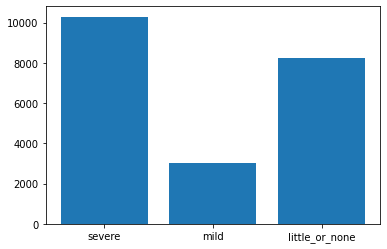

class distribution in dataset: 
num of severe: 621
num of mild: 375
num of little_or_none: 1032
dataset shape: (2028, 4)


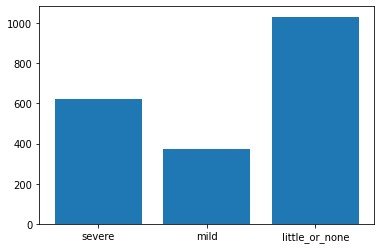

class distribution in dataset: 
num of severe: 604
num of mild: 374
num of little_or_none: 1293
dataset shape: (2271, 4)


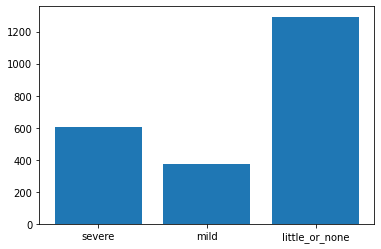

In [9]:
class_distribution(df_train_asonam)
class_distribution(df_dev_asonam)
class_distribution(df_test_asonam)

# Dataset CrisisMMD only

In [10]:
df_train_crisis = get_df_with_eventType(df_train, 'CrisisMMD')
df_dev_crisis = get_df_with_eventType(df_dev, 'CrisisMMD')
df_test_crisis = get_df_with_eventType(df_test, 'CrisisMMD')

class distribution in dataset: 
num of severe: 1648
num of mild: 549
num of little_or_none: 318
dataset shape: (2515, 4)


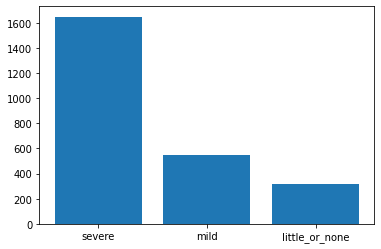

class distribution in dataset: 
num of severe: 131
num of mild: 56
num of little_or_none: 34
dataset shape: (221, 4)


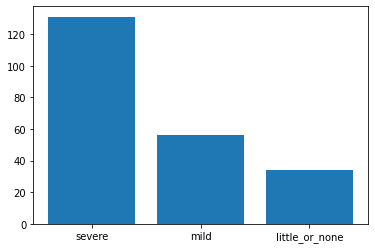

class distribution in dataset: 
num of severe: 272
num of mild: 123
num of little_or_none: 67
dataset shape: (462, 4)


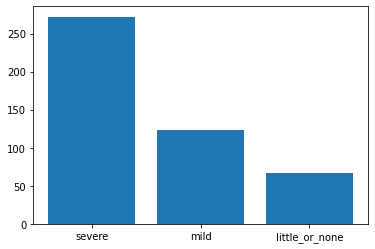

In [11]:
class_distribution(df_train_crisis)
class_distribution(df_dev_crisis)
class_distribution(df_test_crisis)

# Dataset Multimodal only

In [12]:
df_train_modal = get_df_with_eventType(df_train, 'damage_multimodal')
df_dev_modal = get_df_with_eventType(df_dev, 'damage_multimodal')
df_test_modal = get_df_with_eventType(df_test, 'damage_multimodal')

class distribution in dataset: 
num of severe: 877
num of mild: 510
num of little_or_none: 2896
dataset shape: (4283, 4)


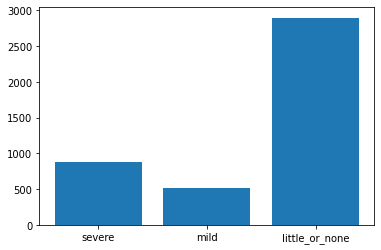

class distribution in dataset: 
num of severe: 93
num of mild: 58
num of little_or_none: 312
dataset shape: (463, 4)


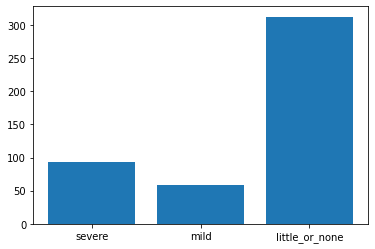

class distribution in dataset: 
num of severe: 225
num of mild: 132
num of little_or_none: 775
dataset shape: (1132, 4)


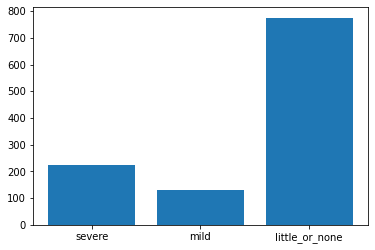

In [13]:
class_distribution(df_train_modal)
class_distribution(df_dev_modal)
class_distribution(df_test_modal)

# Data Exploration

In [14]:
# function for getting folder name
def get_foldername(image_path, i):
  folders = []
  for path in list(image_path):
    folderName = path.split('/')[i]
    folders.append(folderName)

  return folders

def filter_to_desired_source(df, desired, source):
  desired_df = []
  for d in desired:
    desiredSource = df[source] == d
    desired_df.append(df[desiredSource])
  
  return desired_df

### ASONAM

In [15]:
# concat all data from ASANOM distribution
all_df_asonam = pd.concat([df_train_asonam, df_dev_asonam, df_test_asonam], ignore_index=True)
# all_df_asonam = all_df_asonam.reset_index(drop=True)

# get the folder from each ASONAM data
folders = get_foldername(all_df_asonam['image_path'], -2)
sourceFrom = pd.Series(folders)
all_df_asonam['sourceFrom'] = sourceFrom

# filter to desired source
source = ['ecuador_eq', 'ggImage', 'nepal_eq']
desired_all_df_asonam = filter_to_desired_source(all_df_asonam, source, 'sourceFrom')
desired_all_df_asonam = pd.concat(desired_all_df_asonam)
desired_all_df_asonam.head()

,event_name,image_id,image_path,class_label,sourceFrom
0,ASONAM2017,ecuador_eq_severe_im_645.jpg,data/ASONAM17_Damage_Image_Dataset/ecuador_eq/...,severe,ecuador_eq
1,ASONAM2017,ecuador_eq_severe_im_1378.jpg,data/ASONAM17_Damage_Image_Dataset/ecuador_eq/...,severe,ecuador_eq
2,ASONAM2017,ecuador_eq_none_im_2609.jpg,data/ASONAM17_Damage_Image_Dataset/ecuador_eq/...,little_or_none,ecuador_eq
3,ASONAM2017,ecuador_eq_unlabelled_im_100.jpg,data/ASONAM17_Damage_Image_Dataset/ecuador_eq/...,little_or_none,ecuador_eq
4,ASONAM2017,ecuador_eq_mild_im_2573.jpg,data/ASONAM17_Damage_Image_Dataset/ecuador_eq/...,mild,ecuador_eq


class distribution in dataset: 
num of severe: 10161
num of mild: 2391
num of little_or_none: 8832
dataset shape: (21384, 5)


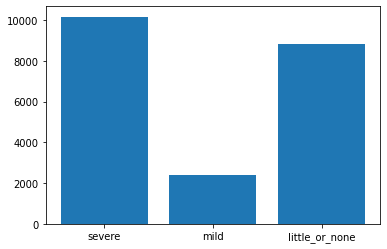

In [16]:
class_distribution(desired_all_df_asonam)

### Multimodal

In [17]:
# concat all data from modal distribution
all_df_modal = pd.concat([df_train_modal, df_dev_modal, df_test_modal], ignore_index=True)
# all_df_modal = all_df_modal.reset_index(drop=True)

# get the folder from each modal data
folders = get_foldername(all_df_modal['image_path'], -3)
sourceFrom = pd.Series(folders)
all_df_modal['sourceFrom'] = sourceFrom

# filter to desired source
source = ['damaged_infrastructure', 'damaged_nature', 'fires', 'flood', 'human_damage']
desired_all_df_modal = filter_to_desired_source(all_df_modal, source, 'sourceFrom')
desired_all_df_modal = pd.concat(desired_all_df_modal)
desired_all_df_modal.head()

,event_name,image_id,image_path,class_label,sourceFrom
1,damage_multimodal,damaged_infrastructure/images/wreckedcar_2017-...,data/multimodal-deep-learning-disaster-respons...,severe,damaged_infrastructure
3,damage_multimodal,damaged_infrastructure/images/destroyedbuildin...,data/multimodal-deep-learning-disaster-respons...,little_or_none,damaged_infrastructure
6,damage_multimodal,damaged_infrastructure/images/floodwater_2017-...,data/multimodal-deep-learning-disaster-respons...,severe,damaged_infrastructure
7,damage_multimodal,damaged_infrastructure/images/earthquake_2017-...,data/multimodal-deep-learning-disaster-respons...,severe,damaged_infrastructure
9,damage_multimodal,damaged_infrastructure/images/wreckedcar_2016-...,data/multimodal-deep-learning-disaster-respons...,severe,damaged_infrastructure


class distribution in dataset: 
num of severe: 1195
num of mild: 700
num of little_or_none: 1011
dataset shape: (2906, 5)


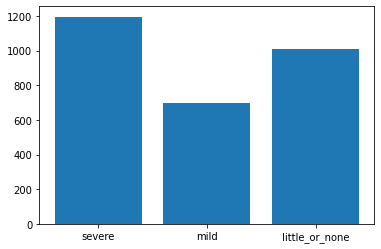

In [18]:
class_distribution(desired_all_df_modal)

### Undersampling

class distribution in dataset: 
num of severe: 10161
num of mild: 2391
num of little_or_none: 8832
dataset shape: (21384, 4)


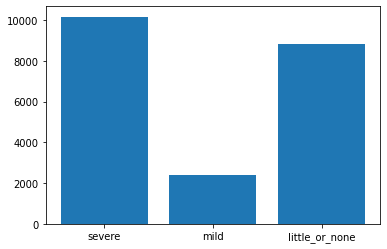

In [19]:
# concat all selected df
feature = ['event_name', 'image_id', 'image_path', 'class_label']
desired_all_df_crisis = pd.concat([df_train_crisis, df_dev_crisis, df_test_crisis], ignore_index=True)
desired_all_df_asonam = desired_all_df_asonam[feature]
desired_all_df_modal = desired_all_df_modal[feature]

# selected_df = pd.concat([desired_all_df_asonam, desired_all_df_crisis, desired_all_df_modal], ignore_index=True)
selected_df = desired_all_df_asonam
class_distribution(selected_df)

class distribution in dataset: 
num of severe: 2400
num of mild: 2391
num of little_or_none: 2400
dataset shape: (7191, 4)


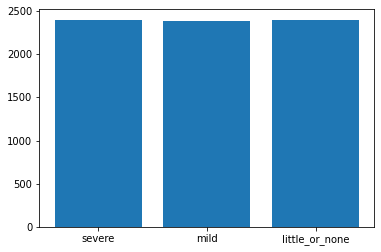

In [20]:
# under-sampling to balancing the class by selecting random n samples
n = 2400
df = selected_df
severe = df['class_label'] == 'severe'
mild = df['class_label'] == 'mild'
little_or_none = df['class_label'] == 'little_or_none'

s = df[severe].sample(n, random_state=42)
m = df[mild]
l = df[little_or_none].sample(n, random_state=42)

uS_desired_selected_df = pd.concat([s, m, l])
class_distribution(uS_desired_selected_df)

In [21]:
# train-test split
label = ['class_label']
x = uS_desired_selected_df
y = uS_desired_selected_df[label]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=42) #85:15
x_train.head()

,event_name,image_id,image_path,class_label
9830,ASONAM2017,nepal_eq_none_im_40407.jpg,data/ASONAM17_Damage_Image_Dataset/nepal_eq/ne...,little_or_none
14179,ASONAM2017,nepal_eq_mild_im_28705.jpg,data/ASONAM17_Damage_Image_Dataset/nepal_eq/ne...,mild
14902,ASONAM2017,nepal_eq_mild_im_16977.jpg,data/ASONAM17_Damage_Image_Dataset/nepal_eq/ne...,mild
21537,ASONAM2017,ecuador_eq_unlabelled_im_929.jpg,data/ASONAM17_Damage_Image_Dataset/ecuador_eq/...,little_or_none
22948,ASONAM2017,nepal_eq_none_im_11598.jpg,data/ASONAM17_Damage_Image_Dataset/nepal_eq/ne...,little_or_none


class distribution in dataset: 
num of severe: 2024
num of mild: 2046
num of little_or_none: 2042
dataset shape: (6112, 4)


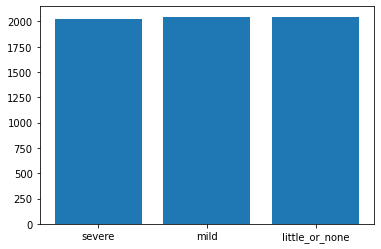

class distribution in dataset: 
num of severe: 376
num of mild: 345
num of little_or_none: 358
dataset shape: (1079, 4)


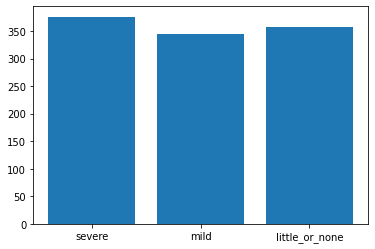

In [22]:
class_distribution(x_train)
class_distribution(x_test)

# Pixels Distribution

In [23]:
# look for pixel distribution
def get_pixel(image_path):
  image_path = os.path.join('./data_damage_severity', image_path)
  im = Image.open('./'+image_path)
  return im.size

img_path = df_train['image_path']
pixels = img_path.map(get_pixel)

width = []
height = []
for w, h in pixels.values:
  width.append(w)
  height.append(h)

width[:5]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


[600, 1000, 880, 600, 720]

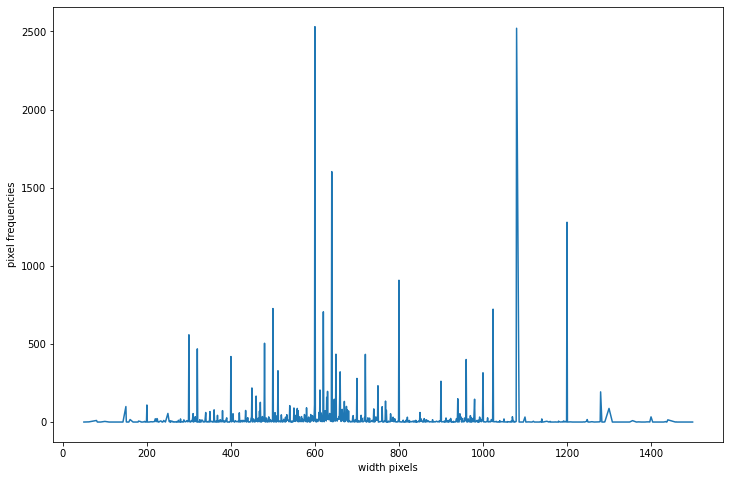

In [24]:
# width
width = [i for i in width if i < 1500]
np_width = np.array(width)
u_width, c_width = np.unique(np_width, return_counts=True)

plt.figure(figsize=(12, 8))
plt.plot(u_width, c_width)
plt.ylabel('pixel frequencies')
plt.xlabel('width pixels')
plt.show()

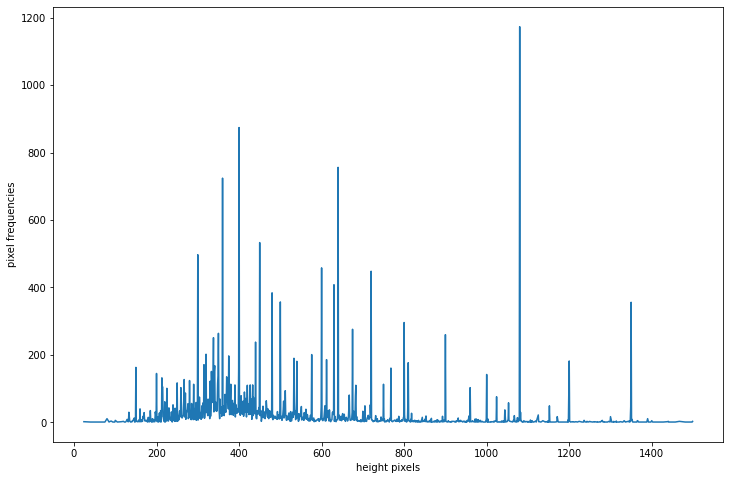

In [25]:
# height
height = [i for i in height if i < 1500]
np_height = np.array(height)
u_height, c_height = np.unique(np_height, return_counts=True)

plt.figure(figsize=(12, 8))
plt.plot(u_height, c_height)
plt.ylabel('pixel frequencies')
plt.xlabel('height pixels')
plt.show()

In [26]:
# median
print('median for width:', np.median(width))
print('median for height:',np.median(height))
print('average:', (np.median(width)+np.median(height))/2)

median for width: 640.0
median for height: 450.0
average: 545.0


# Structuring Folder for ImageDataGenerator

In [27]:
# make directory
try:
  os.mkdir('./dataset')
  os.mkdir('./dataset/train')
  os.mkdir('./dataset/test')
  os.mkdir('./dataset/dev')
  os.mkdir('./dataset/train/severe')
  os.mkdir('./dataset/train/mild')
  os.mkdir('./dataset/train/little_or_none')
  os.mkdir('./dataset/dev/severe')
  os.mkdir('./dataset/dev/mild')
  os.mkdir('./dataset/dev/little_or_none')
  os.mkdir('./dataset/test/severe')
  os.mkdir('./dataset/test/mild')
  os.mkdir('./dataset/test/little_or_none')
except OSError:
  print('there is an error:', OSError)

In [28]:
# cut images from data_image_severity folder to dataset folder
def structuring_folder(images, folder):

  # define the original extracted folder from .tar.gz namely data_damage_severity
  tar_folder = os.path.join(os.getcwd(), 'data_damage_severity')

  # copy from data_damage_severity folder to dataset folder
  for index, image in images.iterrows():
    filename = image['image_path'].split('/')[-1]
    source = os.path.join(tar_folder, image['image_path'])
    destination = os.path.join('{}/{}'.format(folder, image['class_label']), filename)
    copyfile(source, destination)
    # move(source, destination)

In [29]:
# train, dev, test path
train_dir = './dataset/train'
dev_dir = './dataset/dev'
test_dir = './dataset/test'

In [30]:
# structuring train and test dir
structuring_folder(x_train, train_dir)
structuring_folder(x_test, dev_dir)
# structuring_folder(df_test_asonam, test_dir)

# Images Visualization

In [31]:
# def a function to look for the images
def look_images(path, num_images, inches, pic_index):
  ncols = math.floor(math.sqrt(num_images))
  nrows = math.ceil(17/ncols)

  fig = plt.gcf()
  title = ' '.join(re.findall("/+(\w*)", path))
  fig.suptitle(title.capitalize(), size='xx-large', y=0.91)
  fig.set_size_inches(ncols*inches, nrows*inches)
  images_list = os.listdir(path)
  next_images = images_list[pic_index-num_images:pic_index]

  for i, img_path in enumerate(next_images):
    sp = plt.subplot(nrows, ncols, i+1)
    sp.axis('off')

    img = mpimg.imread(os.path.join(path, img_path))
    plt.imshow(img)

  plt.show()

In [32]:
train_mild_dir = './dataset/train/mild'
train_severe_dir = './dataset/train/severe'
train_none_dir = './dataset/train/little_or_none'
validation_mild_dir = './dataset/dev/mild'
validation_severe_dir = './dataset/dev/severe'
validation_none_dir = './dataset/dev/little_or_none'
num_images = 20
inches = 4
pic_index = 0 # images start from

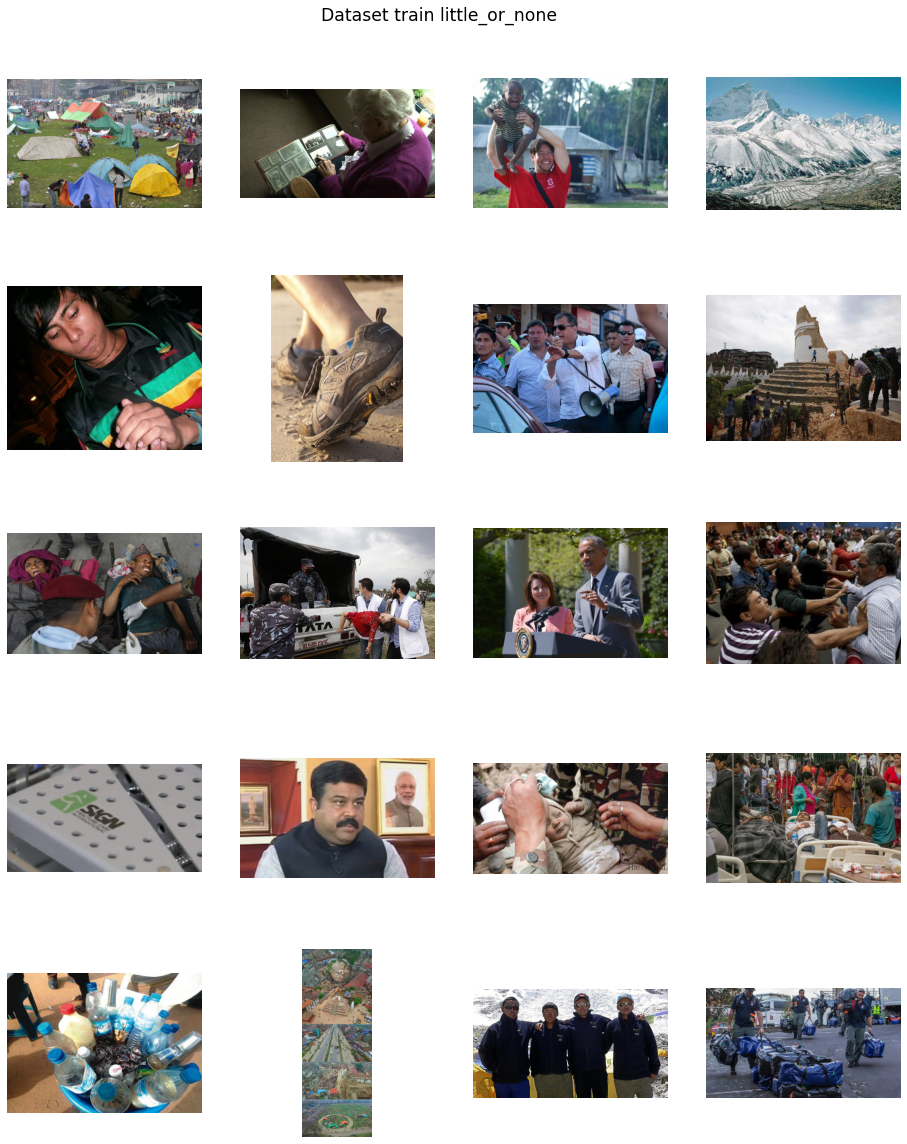

In [33]:
# look for the images
pic_index+=num_images
look_images(train_none_dir, num_images, inches, pic_index)

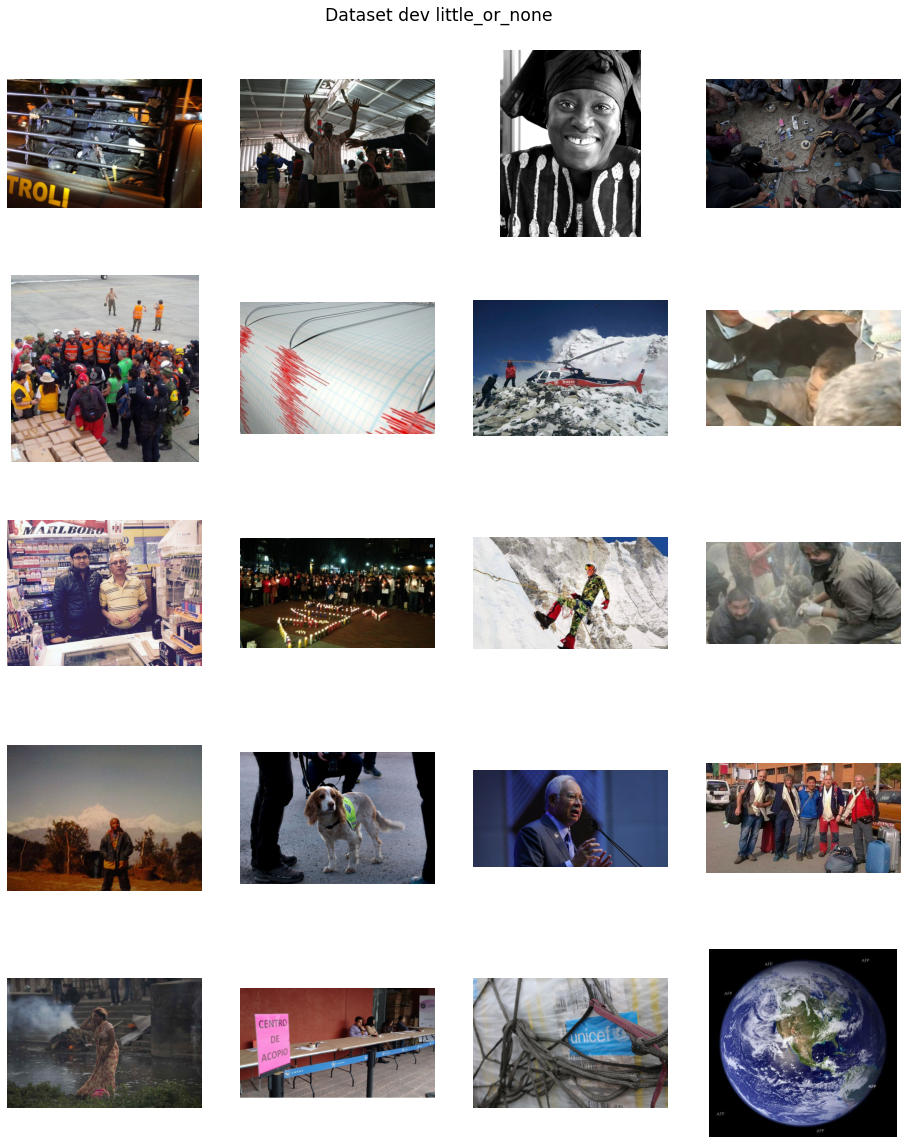

In [34]:
look_images(validation_none_dir, num_images, inches, pic_index)

# Model Building

In [35]:
# define callback
class stopCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, model, logs={}):
    if logs.get("accuracy") > DESIRED_ACCURACY:
      print("\nDesired accuracy has been achieved")
      self.model.stop_training=True

mcp = tf.keras.callbacks.ModelCheckpoint('dmgSev_vgg.hdf5', verbose=1, save_best_only=True)
mcp_res = tf.keras.callbacks.ModelCheckpoint('dmgSev_res.hdf5', verbose=1, save_best_only=True)
mcp_inc = tf.keras.callbacks.ModelCheckpoint('dmgSev_inc.hdf5', verbose=1, save_best_only=True)

In [36]:
# plot model performance
def plot_model_performance():
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  # accuracy
  plt.plot(epochs, acc, 'r', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.legend()
  plt.figure()

  # loss
  plt.plot(epochs, loss, 'r', label='Training Loss')
  plt.plot(epochs, val_loss, 'b', label='Validation Loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

### Model 1 (from scratch model)

In [37]:
# parameter
IMG_SIZE = 300
BATCH_SIZE = 80
channels = 3
num_classes = 3
epochs = 20
DESIRED_ACCURACY = 0.8

train_datagen = ImageDataGenerator(rescale=1./255,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   rotation_range=40)
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='categorical',
                                                    target_size=(IMG_SIZE, IMG_SIZE))

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(dev_dir,
                                                            batch_size=BATCH_SIZE,
                                                            class_mode='categorical',
                                                            target_size=(IMG_SIZE, IMG_SIZE))

# test_datagen = ImageDataGenerator(rescale=1/255.0)
# test_generator = test_datagen.flow_from_directory(test_dir,
#                                                   batch_size=BATCH_SIZE,
#                                                   class_mode='categorical',
#                                                   target_size=(IMG_SIZE, IMG_SIZE))

Found 6112 images belonging to 3 classes.
Found 1079 images belonging to 3 classes.


In [38]:
# # create model
# def create_model():
#   model = tf.keras.models.Sequential([
#     tf.keras.layers.Conv2D(128, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, channels)),
#     tf.keras.layers.MaxPooling2D(2, 2),
#     tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
#     tf.keras.layers.MaxPooling2D(2, 2),
#     tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
#     tf.keras.layers.MaxPooling2D(2, 2),
#     tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
#     tf.keras.layers.MaxPooling2D(2, 2),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(512, activation='relu'),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Dense(256, activation='relu'),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Dense(num_classes, activation='softmax')
#   ])
  
#   return model

# model1 = create_model()
# optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002)
# model1.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
# model1.summary()

In [39]:
# history = model.fit_generator(train_generator,
#                               steps_per_epoch=len(train_generator),
#                               epochs=epochs,
#                               validation_data=validation_generator, 
#                               validation_steps=len(validation_generator))

In [40]:
# plot_model_performance()

#Transfer Learning

## InceptionV3

In [41]:
# # define pre trained model
# pre_trained_model = InceptionV3(input_shape=(IMG_SIZE, IMG_SIZE, channels),
#                                 include_top=False)

# for layer in pre_trained_model.layers:
#   layer.trainable = False

# pre_trained_model.summary()

In [42]:
# # get last layer
# last_layer = pre_trained_model.get_layer('mixed8')
# print('last layer output shape:', last_layer.output_shape)
# last_output = last_layer.output

# # construct new model with pre-trained model
# x = tf.keras.layers.Flatten()(last_output)
# x = tf.keras.layers.Dense(512, activation='relu')(x)
# x = tf.keras.layers.Dropout(0.2)(x)
# # x = tf.keras.layers.Dense(256, activation='relu')(x)
# # x = tf.keras.layers.Dropout(0.2)(x)
# x = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

# model2 = Model(pre_trained_model.input, x)
# optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)
# model2.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
# model2.summary()

In [43]:
# history = model2.fit_generator(train_generator,
#                               steps_per_epoch=len(train_generator),
#                               epochs=epochs,
#                               validation_data=validation_generator, 
#                               validation_steps=len(validation_generator), callbacks=[mcp_inc])

In [44]:
# plot_model_performance()
# # save model
# model2.save('./dmgSev_inc2.h5')

## VGG 16

In [45]:
# define pre trained model
pre_trained_model = VGG16(input_shape=(IMG_SIZE, IMG_SIZE, channels),
                                include_top=False)

for layer in pre_trained_model.layers:
  layer.trainable = False

pre_trained_model.summary()

58892288/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 300, 300, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 300, 300, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 300, 300, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 150, 150, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 150, 150, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 150, 150, 128)     147584    
______________________________________________________________

In [46]:
# get last layer
last_layer = pre_trained_model.get_layer('block5_pool')
print('last layer output shape:', last_layer.output_shape)
last_output = last_layer.output

# construct new model with pre-trained model
x = tf.keras.layers.Flatten()(last_output)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

model3 = Model(pre_trained_model.input, x)
optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002)
model3.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model3.summary()

last layer output shape: (None, 9, 9, 512)
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 300, 300, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 300, 300, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 300, 300, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 150, 150, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 150, 150, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 150, 150, 128)     147584    
_________________________________________________________________
block2_pool (MaxPo

In [47]:
history = model3.fit_generator(train_generator,
                              steps_per_epoch=len(train_generator),
                              epochs=epochs,
                              validation_data=validation_generator, 
                              validation_steps=len(validation_generator), callbacks=[mcp])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
71/77 [==========================>...] - ETA: 13s - loss: 1.1111 - accuracy: 0.4901

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


77/77 [==============================] - 246s 3s/step - loss: 1.0931 - accuracy: 0.4964 - val_loss: 0.8086 - val_accuracy: 0.6450

Epoch 00001: val_loss improved from inf to 0.80863, saving model to dmgSev_vgg.hdf5
Epoch 2/20
77/77 [==============================] - 174s 2s/step - loss: 0.8411 - accuracy: 0.6122 - val_loss: 0.7574 - val_accuracy: 0.6645

Epoch 00002: val_loss improved from 0.80863 to 0.75743, saving model to dmgSev_vgg.hdf5
Epoch 3/20
77/77 [==============================] - 175s 2s/step - loss: 0.8041 - accuracy: 0.6304 - val_loss: 0.7870 - val_accuracy: 0.6719

Epoch 00003: val_loss did not improve from 0.75743
Epoch 4/20
77/77 [==============================] - 174s 2s/step - loss: 0.7762 - accuracy: 0.6494 - val_loss: 0.7280 - val_accuracy: 0.6840

Epoch 00004: val_loss improved from 0.75743 to 0.72796, saving model to dmgSev_vgg.hdf5
Epoch 5/20
77/77 [==============================] - 173s 2s/step - loss: 0.7610 - accuracy: 0.6569 - val_loss: 0.7464 - val_accuracy

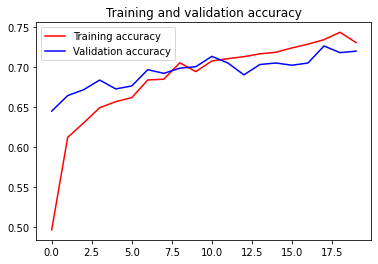

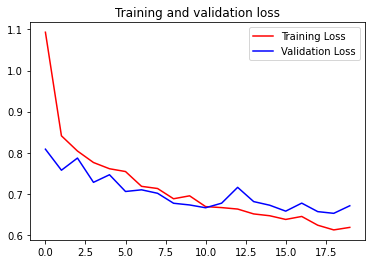

In [48]:
plot_model_performance()

In [49]:
# save model
model3.save('./dmgSev_vgg2.h5')

## ResNet50


In [50]:
# # define pre trained model
# pre_trained_model = ResNet50(input_shape=(IMG_SIZE, IMG_SIZE, channels),
#                                 include_top=False)

# for layer in pre_trained_model.layers:
#   layer.trainable = False

# pre_trained_model.summary()

In [51]:
# # get last layer
# last_layer = pre_trained_model.get_layer('conv4_block6_add')
# print('last layer output shape:', last_layer.output_shape)
# last_output = last_layer.output

# # construct new model with pre-trained model
# x = tf.keras.layers.Flatten()(last_output)
# x = tf.keras.layers.Dense(512, activation='relu')(x)
# x = tf.keras.layers.Dropout(0.2)(x)
# x = tf.keras.layers.Dense(256, activation='relu')(x)
# x = tf.keras.layers.Dropout(0.2)(x)
# x = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

# model4 = Model(pre_trained_model.input, x)
# optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002)
# model4.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
# model4.summary()

# Prediction
predicting single image

In [72]:
# # mount to drive
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [81]:
# load saved model
# my_model = tf.keras.models.load_model('./drive/MyDrive/dmgSev_vgg2.h5')
my_model = model3
my_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 300, 300, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 300, 300, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 300, 300, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 150, 150, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 150, 150, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 150, 150, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 75, 75, 128)       0     

Saving mild.jpg to mild.jpg
Saving none.jpg to none.jpg
Saving severe2.png to severe2.png


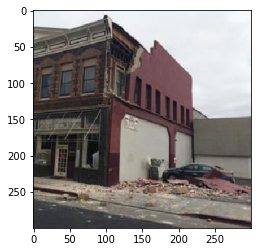

predicted category: severe


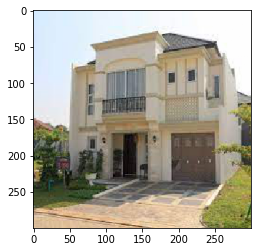

predicted category: mild


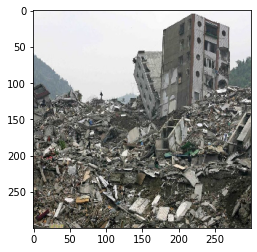

predicted category: severe
rm: cannot remove '*.jpeg': No such file or directory


In [92]:
# upload and predict single image
from google.colab import files
from keras.preprocessing import image

uploaded=files.upload()
category = ['little_or_none', 'mild', 'severe']

for fn in uploaded.keys():
 
  # predicting images
  path='/content/' + fn
  img=image.load_img(path, target_size=(IMG_SIZE, IMG_SIZE))
  
  x=image.img_to_array(img)
  x=np.expand_dims(x, axis=0)
  images = np.vstack([x])/255 #normalization
  
  classes = my_model.predict(images, batch_size=BATCH_SIZE)
  label = np.argmax(classes)
  plt.imshow(images[0])
  plt.show()
  print('predicted category:', category[label])

!rm *.jpg *.png *.jpeg

# Evaluation

In [53]:
pred= model3.predict_generator(validation_generator)
predicted_class_indices=np.argmax(pred,axis=1)
labels=(validation_generator.class_indices)
labels2=dict((v,k) for k,v in labels.items())
predictions=[labels2[k] for k in predicted_class_indices]
print(predicted_class_indices)
print(labels)
print(predictions)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


[2 0 1 ... 0 2 1]
{'little_or_none': 0, 'mild': 1, 'severe': 2}
['severe', 'little_or_none', 'mild', 'little_or_none', 'little_or_none', 'severe', 'mild', 'little_or_none', 'severe', 'mild', 'little_or_none', 'severe', 'mild', 'severe', 'mild', 'severe', 'mild', 'severe', 'little_or_none', 'severe', 'severe', 'severe', 'severe', 'little_or_none', 'severe', 'severe', 'severe', 'mild', 'mild', 'severe', 'little_or_none', 'mild', 'little_or_none', 'mild', 'mild', 'severe', 'severe', 'mild', 'little_or_none', 'severe', 'mild', 'severe', 'severe', 'little_or_none', 'severe', 'mild', 'severe', 'little_or_none', 'little_or_none', 'little_or_none', 'little_or_none', 'severe', 'little_or_none', 'mild', 'little_or_none', 'little_or_none', 'mild', 'little_or_none', 'mild', 'little_or_none', 'severe', 'severe', 'little_or_none', 'mild', 'severe', 'little_or_none', 'little_or_none', 'severe', 'mild', 'severe', 'severe', 'mild', 'little_or_none', 'mild', 'severe', 'little_or_none', 'severe', 'severe

In [54]:
true_labels = validation_generator.classes
true_labels

x_test_copy = x_test.copy()
x_test_copy = x_test_copy.reset_index()

s_predictions = pd.Series(predictions)
x_test_copy['predicted'] = s_predictions
x_test_copy.head()

,index,event_name,image_id,image_path,class_label,predicted
0,15794,ASONAM2017,nepal_eq_mild_im_64.jpg,data/ASONAM17_Damage_Image_Dataset/nepal_eq/ne...,mild,severe
1,14396,ASONAM2017,nepal_eq_mild_im_40539.jpg,data/ASONAM17_Damage_Image_Dataset/nepal_eq/ne...,mild,little_or_none
2,11885,ASONAM2017,nepal_eq_none_im_42917.jpg,data/ASONAM17_Damage_Image_Dataset/nepal_eq/ne...,little_or_none,mild
3,19698,ASONAM2017,nepal_eq_mild_im_19658.jpg,data/ASONAM17_Damage_Image_Dataset/nepal_eq/ne...,mild,little_or_none
4,4057,ASONAM2017,nepal_eq_severe_im_26869.jpg,data/ASONAM17_Damage_Image_Dataset/nepal_eq/ne...,severe,little_or_none
5,17469,ASONAM2017,nepal_eq_mild_im_12427.jpg,data/ASONAM17_Damage_Image_Dataset/nepal_eq/ne...,mild,severe
6,22440,ASONAM2017,nepal_eq_none_im_34170.jpg,data/ASONAM17_Damage_Image_Dataset/nepal_eq/ne...,little_or_none,mild
7,6921,ASONAM2017,nepal_eq_severe_im_10509.jpg,data/ASONAM17_Damage_Image_Dataset/nepal_eq/ne...,severe,little_or_none
8,18502,ASONAM2017,nepal_eq_severe_im_38653.jpg,data/ASONAM17_Damage_Image_Dataset/nepal_eq/ne...,severe,severe
9,14828,ASONAM2017,nepal_eq_none_im_24690.jpg,data/ASONAM17_Damage_Image_Dataset/nepal_eq/ne...,little_or_none,mild


In [55]:
# get most misclassified
er_class = {
    'mild':0,
    'severe':0,
    'little_or_none':0
}
good_class ={
    'mild':0,
    'severe':0,
    'little_or_none':0
}
for index, image in x_test_copy.iterrows():
  if image['class_label'] != image['predicted']:
    er_class[image['class_label']] += 1
  else:
    good_class[image['class_label']] += 1

print('true predicted:', good_class)
print('false predicted:', er_class)

true predicted: {'mild': 82, 'severe': 136, 'little_or_none': 121}
false predicted: {'mild': 263, 'severe': 240, 'little_or_none': 237}


# Additional code that might be useful

## removing something

In [ ]:
# !rm -rf ./dataset

In [ ]:
# !rm ./dmgSev_vgg.hdf5

In [ ]:
# !rm ./dmgSev_vgg2.5

In [ ]:
# !rm ./dmgSev_inc.hdf5

In [ ]:
# !rm ./dmgSev_inc2.h5

## copy model to google drive

In [69]:
# from google.colab import drive
# drive.mount('/content/drive')

# !zip dmgSev.zip dmgSev_vgg2.h5 dmgSev_vgg.hdf5
# !cp dmgSev_vgg2.h5 ./drive/MyDrive/dmgSev_vgg2.h5
# !cp dmgSev.zip ./drive/MyDrive/dmgSev.zip
# !cp dmgSev_vgg.hdf5 ./drive/MyDrive/dmgSev_vgg.hdf5

# drive.flush_and_unmount()
# print('All changes made in this colab session should now be visible in Drive.')

Mounted at /content/drive
